#### Data Science Imports

In [1]:
import pandas as pd, os, matplotlib.pyplot as plt, numpy as np, collections, tqdm, textwrap as tw, random, scipy
import sklearn.metrics as metrics
from matplotlib import rcParams
from matplotlib.markers import MarkerStyle
import math, inspect, numpy as np
from typing import Callable, Union
rcParams['font.family'] = "P052"
try:
    pass
    %load_ext autoreload
    %autoreload 2
    %config InlineBackend.figure_format = 'png'
except SyntaxError:
    pass

os.chdir("/Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/discovery/nature_atlas/")


#### Defining Functions

In [2]:
Freedman_Diaconis_rule_n_bins = lambda x: int(round(((max(x) - min(x))/(2*(np.percentile(x, 75) - np.percentile(x, 25))*len(x)**(-1/3))), 0))

normalize_ranks = lambda obj_to_norm, starting_ranks, ending_ranks: obj_to_norm*(ending_ranks-1)/(starting_ranks-1) + (starting_ranks-ending_ranks)/(starting_ranks-1)

#### Reading in Data

In [3]:
their_ranks = pd.read_csv("./their_ranks.csv", index_col=0)
our_ranks = pd.read_csv("./our_ranks.csv", index_col=0)
their_percentiles = pd.read_csv("./their_percentiles.csv", index_col=0)
our_percentiles = pd.read_csv("./our_percentiles.csv", index_col=0)
our_raw_scores = pd.read_csv("./our_raw_scores.csv", index_col=0)

#### Make a "Pseudo" confusion matrix

In [4]:
K = 3
# Pseudo Confusion Matrix: Cell (X, Y) will be 
# incremented when a site has rank >= K for their kinase X, our kinase Y.
# Initialize np array of zeros, of shape (num_their_kins, num_our_kins)
num_their_kins = len(their_ranks.columns)
num_our_kins = len(our_ranks.columns)
assert num_their_kins == num_our_kins, "The number of kinases in our ranks and their ranks are not the same"
assert K <= num_their_kins, "K is greater than the number of kinases"
assert K <= num_our_kins, "K is greater than the number of kinases"
assert np.all(our_ranks.columns == their_ranks.columns), "Columns are not aligned"
assert np.all(our_ranks.index == their_ranks.index), "Indexes are not aligned"
confusion_matrix = pd.DataFrame(np.zeros((num_their_kins, num_our_kins)))
confusion_matrix.columns = pd.Series(their_ranks.columns).apply(lambda x: x.replace("", ""))
confusion_matrix.index = pd.Index(pd.Series(our_ranks.columns).apply(lambda x: x.replace("", "")))
# Make sure the two dataframes of ranks have indexes exactly the same and aligned
for i, r in tqdm.tqdm(our_ranks.iterrows(), total = len(our_ranks.index)):
    # Get the ranks of the site for each kinase
    assert(isinstance(i, str))
    our_ranks_for_site_argsort = np.argsort(np.asarray(r.values))
    their_ranks_for_site_argsort = np.argsort(np.asarray(their_ranks.loc[i].values))
    for k in range(K):
        our_kth_kinase = our_ranks.columns[our_ranks_for_site_argsort[k]]
        their_kth_kinase = their_ranks.columns[their_ranks_for_site_argsort[k]]
        # Increment the cell (their_kinase, our_kinase) in the confusion matrix
        confusion_matrix.at[our_kth_kinase, their_kth_kinase] += 1
cm = confusion_matrix.values

100%|██████████| 86189/86189 [00:08<00:00, 9881.73it/s] 


Text(0.0, 1.0, 'Num Sites')

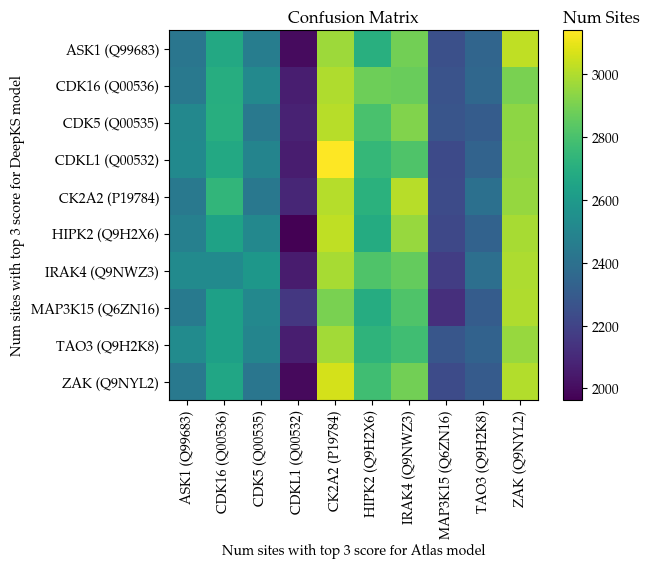

In [5]:
a = metrics.ConfusionMatrixDisplay(cm, display_labels=[x.replace("^Pctl", "").replace("^Rank", "").replace("|['", " (").replace("']", "").replace("['", "") + ")" for x in confusion_matrix.columns.tolist()])
a.plot(include_values=False)
_ = plt.xticks(*plt.xticks(), rotation=90) # type: ignore
_ = plt.ylabel(f"Num sites with top {K} score for DeepKS model")
_ = plt.xlabel(f"Num sites with top {K} score for Atlas model")
_ = plt.title(f"Confusion Matrix")
# _ = plt.gca().set_title("Num Sites")
plt.gcf().axes[1].set_title("Num Sites", loc='left')

#### Get distance between ranks

In [6]:
D = 3

# random simulation
base = list(range(1, 11))
many_sites_A = [random.sample(base, k=10) for _ in range(86000)]
many_sites_B = [random.sample(base, k=10) for _ in range(86000)]
for c in range(10):
    dist_within_d = 0
    dist_not_within_d = 0
    for i, (t, o) in enumerate(zip(many_sites_A, many_sites_B)):
        if abs(t[c] - o[c]) <= D:
            dist_within_d += 1
        else:
            dist_not_within_d += 1
    print(f"{c=}: {dist_within_d} within {D}, {dist_not_within_d} not within {D}")

c=0: 49944 within 3, 36056 not within 3
c=1: 49861 within 3, 36139 not within 3
c=2: 49920 within 3, 36080 not within 3
c=3: 49782 within 3, 36218 not within 3
c=4: 49620 within 3, 36380 not within 3
c=5: 50012 within 3, 35988 not within 3
c=6: 49888 within 3, 36112 not within 3
c=7: 50001 within 3, 35999 not within 3
c=8: 49963 within 3, 36037 not within 3
c=9: 49932 within 3, 36068 not within 3


#### Compare rank distributions between DeepKS and Atlas

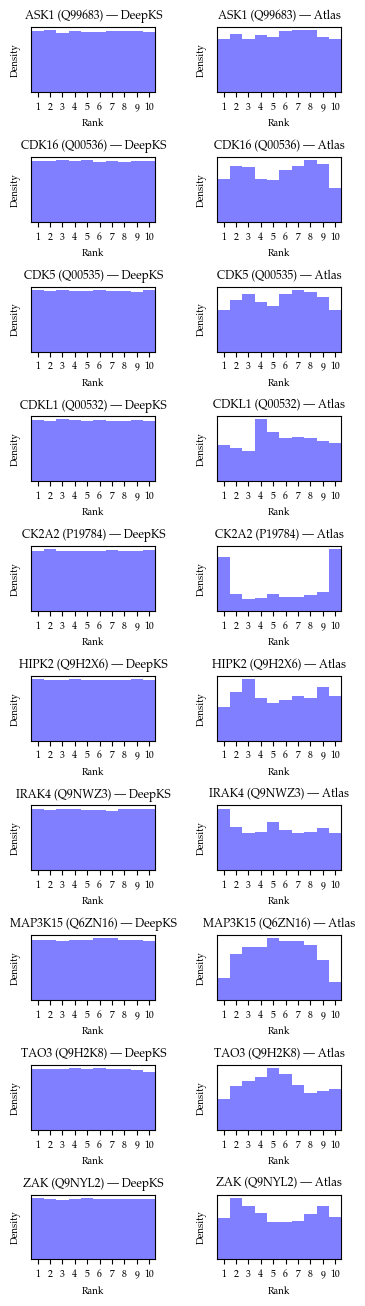

In [7]:
rcParams['font.size'] = 7
titles = [x.replace("^Pctl", "").replace("^Rank", "").replace("|['", " (").replace("']", "").replace("['", "") + ")" for x in confusion_matrix.columns.tolist()]

fig, ax = plt.subplots(nrows=10, ncols=2, figsize = (4, 16), gridspec_kw={'width_ratios': [0.5, 0.5], 'hspace': 1, 'wspace': 0.5})
for j, ranks in enumerate([our_ranks, their_ranks]):
    for i, c in enumerate(ranks.columns):
        ax[i][j].hist(ranks[c], bins=[0.5+x for x in range(11)], color='blue', alpha=0.5, align='mid', density=True)
        ax[i][j].set_xlim(0.5, 10.5)
        ax[i][j].set_xlabel("Rank")
        ax[i][j].set_ylabel("Density")
        ax[i][j].set_yticks([], [])
        ax[i][j].set_xticks(range(1, 11), [str(x) for x in range(1, 11)])
        ax[i][j].set_title(f"{titles[i]} — {'DeepKS' if j == 0 else 'Atlas'}")

#### Get distributions and QQ plots of our raw scores

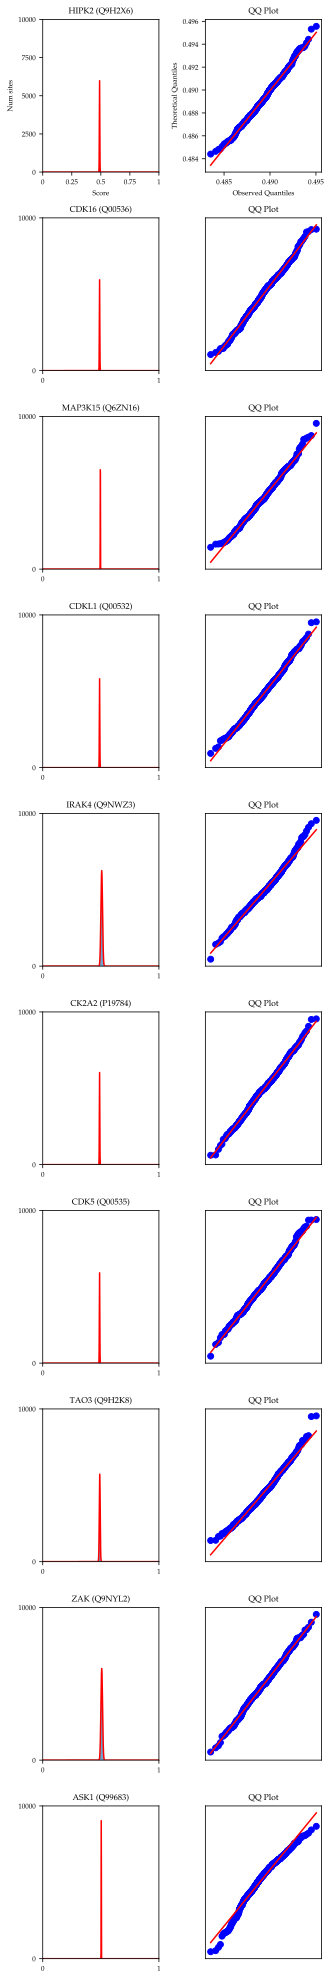

In [8]:
import random
from scipy.stats.distributions import norm
from scipy import stats
import sys
sys.stderr = open("/dev/null", "w")
%config InlineBackend.figure_format = 'svg'

KINS = our_raw_scores.columns
# Check distribution of raw scores for KIN
fig, axs = plt.subplots(nrows=len(KINS), ncols=2, figsize=(5, len(KINS)*3.5), gridspec_kw={'hspace': 0.3, 'wspace': 0.4})
for i, KIN in enumerate(KINS):
    hist_info = axs[i][0].hist(our_raw_scores[KIN], bins=50, density=False)
    _ = axs[i][0].set_xlim(0, 1)
    _ = axs[i][0].set_ylim(0, 10000)
    _ = axs[i][0].set_title(str(KIN).replace("[", "").replace("]", "").replace("'", "").replace(" ", "").replace("^Score", "").replace("|", " (") + ")")
    _ = axs[i][0].set_yticks([], [])
    _ = axs[i][0].set_xlabel("Score" if i == 0 else "")
    _ = axs[i][0].set_ylabel("Num sites" if i == 0 else "")
    _ = axs[i][0].set_yticks([0, 2500, 5000, 7500, 10000] if i == 0 else [0, 10000], [0, 2500, 5000, 7500, 10000] if i == 0 else [0, 10000])
    _ = axs[i][0].set_xticks([0, 0.25, 0.5, 0.75, 1] if i == 0 else [0, 1], [0, 0.25, 0.5, 0.75, 1] if i == 0 else [0, 1])
    max_hist_value = max(hist_info[0])
    X = np.linspace(0, 1, 1000)
    Y = (norm.pdf(np.linspace(0, 1, 1000), loc=np.mean(our_raw_scores[KIN]), scale=np.std(our_raw_scores[KIN]))*len(our_raw_scores[KIN]))
    _ = axs[i][0].plot(X, Y/(max(Y)/max_hist_value), color='red')
    modified_comparison = lambda: norm(loc=np.mean(our_raw_scores[KIN]), scale=np.std(our_raw_scores[KIN]))
    _ = stats.probplot(random.sample(our_raw_scores[KIN].tolist(), k=500), sparams = (np.mean(our_raw_scores[KIN]), np.std(our_raw_scores[KIN])), plot=axs[i][1])
    _ = axs[i][1].set_title("QQ Plot")
    _ = axs[i][1].set_xlabel("Observed Quantiles" if i == 0 else "")
    _ = axs[i][1].set_ylabel("Theoretical Quantiles" if i == 0 else "")
    if i != 0:
        _ = axs[i][1].set_yticks([0, 2500, 5000, 7500, 10000] if i == 0 else [], [0, 2500, 5000, 7500, 10000] if i == 0 else [])
        _ = axs[i][1].set_xticks([0, 0.25, 0.5, 0.75, 1] if i == 0 else [], [0, 0.25, 0.5, 0.75, 1] if i == 0 else [])

#### Make scatterplot of percentile vs. percentile

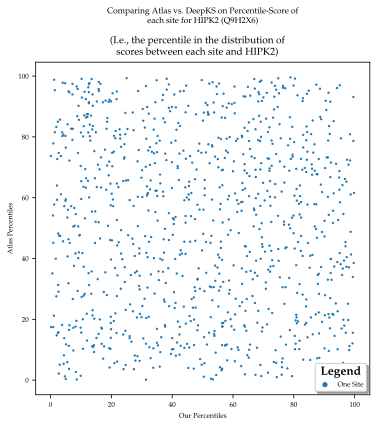

In [9]:
assert len(our_percentiles) == len(their_percentiles), "The number of sites is not the same between our percentiles and their percentiles"
assert set(our_percentiles.index) == set(their_percentiles.index), "The set of indices (symbols) is not the same between our percentiles and their percentiles"
assert np.all(their_percentiles.index == our_percentiles.index), "The order of indices (symbols) is not the same between our percentiles and their percentiles"

fig = plt.figure(figsize=(6, 8))

KIN = str(their_percentiles.columns[5])
inds = list(range(len(their_percentiles[KIN])))
inds = random.sample(inds, k=1000)
_ = plt.gca().set_aspect(1)
X = our_percentiles[KIN.replace("]^Pctl", "]^Score")].tolist()
X = [X[i] for i in inds]
Y = their_percentiles[KIN].tolist()
Y = [Y[i] for i in inds]
plt.scatter(X, Y, label="One Site", marker=MarkerStyle("o"), s=2)
plt.xlabel("Our Percentiles")
plt.ylabel("Atlas Percentiles")
nice_kin = KIN.replace("|['", " (").replace("]", "").replace("'", "").replace("^Pctl", "").replace("[", "") + ")"
the_title = tw.fill(f"Comparing Atlas vs. DeepKS on Percentile-Score of each site for " + nice_kin, width=50, replace_whitespace=False)
the_subtitle = tw.fill("\n(I.e., the percentile in the distribution of scores between each site and "+ nice_kin.split(" ")[0] + ")", width=50, replace_whitespace=False)

plt.title(the_title, y = 1.1)
plt.suptitle(the_subtitle, fontsize=10, y = 0.85)
_ = plt.legend(loc="lower right", fancybox=True, shadow=True, title="Legend", markerscale=3, title_fontproperties = {'size': 12, 'weight': 'bold'})

#### Make scatterplot of raw score vs. atlas percentile (full)

In [10]:
assert len(our_percentiles) == len(their_percentiles), "The number of sites is not the same between our percentiles and their percentiles"
assert set(our_percentiles.index) == set(their_percentiles.index), "The set of indices (symbols) is not the same between our percentiles and their percentiles"
assert np.all(their_percentiles.index == our_percentiles.index), "The order of indices (symbols) is not the same between our percentiles and their percentiles"

fig = plt.figure(figsize=(18, 18))

KIN = str(their_percentiles.columns[5])
inds = list(range(len(their_percentiles[KIN])))
inds = random.sample(inds, k=len(inds))
plt.gca().set_aspect(.1/110)
X = our_raw_scores[KIN.replace("^Pctl^Pctl", "^Score")].tolist()
X = [X[i] for i in inds]
Y = their_percentiles[KIN].tolist()
Y = [Y[i] for i in inds]
plt.scatter(X, Y, label="One Site", marker=MarkerStyle("o"), s=2)
plt.xlim(0.45, 0.55)
plt.ylim(-5, 105)
plt.xlabel("Our Raw Scores")
plt.ylabel("Atlas Percentiles")
nice_kin = KIN.replace("|['", " (").replace("]", "").replace("'", "").replace("^Pctl", "").replace("[", "") + ")"
the_title = tw.fill(f"Comparing Atlas vs. DeepKS on Percentile-Score of each site for " + nice_kin, width=50, replace_whitespace=False)
the_subtitle = tw.fill("\n(I.e., the percentile in the distribution of scores between each site and "+ nice_kin.split(" ")[0] + ")", width=50, replace_whitespace=False)

plt.title(the_subtitle, fontsize=10)
plt.suptitle(the_title, fontsize=14)
_ = plt.legend(loc="lower right", fancybox=True, shadow=True, title="Legend", markerscale=3, title_fontproperties = {'size': 12, 'weight': 'bold'})
plt.savefig("atlas_vs_deepks_percentile_score.png", dpi=300)
plt.close()

#### Make scatterplot of rank vs. rank

(-1.5, 11.5)

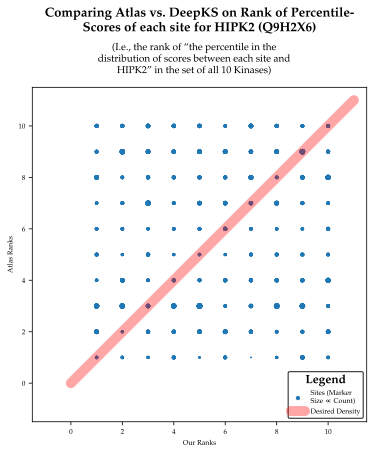

In [11]:
fig = plt.figure(figsize=(6, 9))

KIN = str(their_ranks.columns[5])
inds = list(range(len(their_ranks[KIN])))
inds = random.sample(inds, k=1000)
_ = plt.gca().set_aspect(1)
X = our_ranks[KIN].tolist()
X = [X[i] for i in inds]
Y = their_ranks[KIN].tolist()
Y = [Y[i] for i in inds]
coord_to_count = collections.Counter((i, j) for i, j in zip(X, Y))
coord_to_size = {(i, j): coord_to_count[(i, j)] for i in range(1, 11) for j in range(1, 11)}
plt.scatter(X, Y, label="Sites (Marker\nSize ∝ Count)", marker=MarkerStyle('o'), s=[coord_to_size[(i, j)] for i, j in zip(X, Y)])
plt.xlabel("Our Ranks")
plt.ylabel("Atlas Ranks")
nice_kin = KIN.replace("|['", " (").replace("]", "").replace("'", "").replace("^Rank^Pctl", "").replace("[", "") + ")"
the_title = tw.fill(f"Comparing Atlas vs. DeepKS on Rank of Percentile-Scores of each site for " + nice_kin, width=50, replace_whitespace=False)
the_subtitle = tw.fill("\n(I.e., the rank of “the percentile in the distribution of scores between each site and "+ nice_kin.split(" ")[0] + "” in the set of all 10 Kinases)", width=50, replace_whitespace=False)

plt.title(the_title, y = 1.15, fontdict={'weight': 'bold', 'size': 13})
plt.suptitle(the_subtitle, fontsize=10, y = 0.84)
plt.plot([0, 11], [0, 11], color='red', linestyle='-', linewidth=10, label='Desired Density', alpha=0.35, solid_capstyle='round')
_ = plt.legend(loc="lower right", shadow=False, fancybox=True, title="Legend", scatterpoints = 1, title_fontproperties = {'size': 12, 'weight': 'bold'}, edgecolor='black', framealpha=0.9)
plt.xlim(-1.5, 11.5)
plt.ylim(-1.5, 11.5)

483


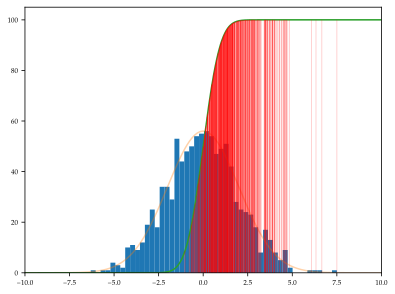

In [12]:
random.seed(42)
score_dist = scipy.stats.norm(loc=0, scale=2).pdf
scores_out = sorted([random.gauss(0, 2) for _ in range(1000)])
true_cdf = scipy.stats.norm(loc=0, scale=.75).cdf
X = np.linspace(-10, 10, 1000)
info = plt.hist(scores_out, bins=50)
max_height = max(info[0])
base_score_dist = [score_dist(x) for x in X]
plt.plot(X, [score_dist(x)*max_height/max(base_score_dist) for x in X], alpha = 0.35)
plt.plot(X, true_cdf_pnts := [true_cdf(x)*100/true_cdf(10) for x in X])
truths = []
for score in scores_out:
    if random.random() < true_cdf(score)/true_cdf(10):
        truths.append(True)
        plt.vlines(score, 0, true_cdf(score)*100/true_cdf(10), color='red', alpha=0.35, linewidth=0.5)
    else:
        truths.append(False)
plt.xlim(-10, 10)
print(sum(truths))

0.9644949561693318


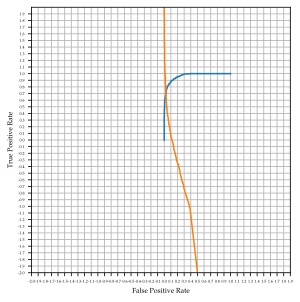

In [13]:
# Make simulated ROC curve based on previous cell
%config InlineBackend.figure_format = 'svg'
import sklearn.metrics
fpr, tpr, thresh = sklearn.metrics.roc_curve(truths, scores_out)
sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
rocauc = sklearn.metrics.roc_auc_score(truths, scores_out)
plt.plot(fpr, thresh)
print(rocauc)
thsh_to_score = {t: s for t, s in zip(thresh, scores_out)}
plt.grid(True, 'both', 'both')
ticks = np.arange(-2, 2, 0.1)
tick_labels = [f"{t:.1f}" for t in ticks]
plt.xticks(ticks, tick_labels, fontsize=4)
_ = plt.yticks(ticks, tick_labels, fontsize=4)
plt.ylim(-2, 2)
plt.gca().set_aspect(1)

In [14]:
def raw_score_to_probability(
    scores: list[Union[float, int]], truths: list[bool], incr=0.2, plot=False, true_cdf=None
) -> Callable[[Union[int, float, list[Union[float, int]]]], float]:
    assert sorted(scores) == scores, f"`{inspect.stack()[0][3]}` requires sorted scores as input."
    assert len(scores) == len(truths), f"`{inspect.stack()[0][3]}` requires equal length of scores and truths."
    i = 0
    places = int(np.ceil(-np.log10(incr)))
    l_orig = round(np.floor(min(scores) * 10 ** places) / 10 ** places, places)
    l = l_orig
    r = l + incr
    probs = []
    midpoints = []
    while i < len(scores):
        count = 0
        total = 0
        while i < len(scores) and l <= scores[i] < r:
            if truths[i]:
                count += 1
            total += 1
            i += 1
        if total != 0:
            midpoints.append(mp := (l + r) / 2)  # type: ignore
            probs.append(prob := count / total)  # type: ignore
            # print("Cutoff {:.3f} = Prob {:.4f}".format(mp, prob))
        l += incr
        r += incr
    base_fn = lambda x, c, d: 1 / (1 + math.e ** (-c * (x - d)))
    params, *_ = scipy.optimize.curve_fit(base_fn, midpoints, probs)
    convert_fn = lambda x: base_fn(x, *params)
    if plot:
        plt.plot(midpoints, probs, "go-", label="Actual Data", markersize=1, linewidth=0.5)
        X = np.linspace(l_orig, max(scores), endpoint=True, num=1000)
        plt.plot(X, [convert_fn(x) for x in X], label="Approximated function(raw score) => probability", linewidth=0.5)
        if true_cdf is not None:
            plt.plot(X, [true_cdf(x) / true_cdf(10) for x in X], label="True function(raw score) => probability", linewidth=0.5)
        plt.legend()
        plt.xlabel("Raw score")
        plt.ylabel("Estimated non-decoy fraction given raw score")
        plt.title("Converting raw score into a true estimated probability")
    return convert_fn


<function __main__.raw_score_to_probability.<locals>.<lambda>(x)>

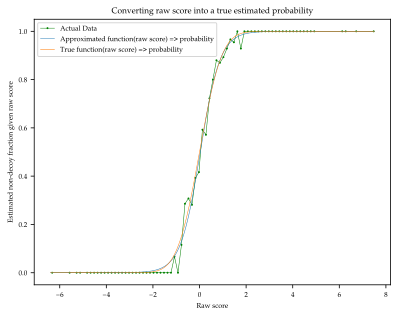

In [15]:
raw_score_to_probability(scores_out, truths, plot=True, true_cdf=true_cdf, incr=0.15)